Cronbach's Alpha (Gesamt): 0.754

Interpretation:
α ≥ 0.9: Exzellent
0.8 ≤ α < 0.9: Gut
0.7 ≤ α < 0.8: Akzeptabel
α < 0.7: Fragwürdig


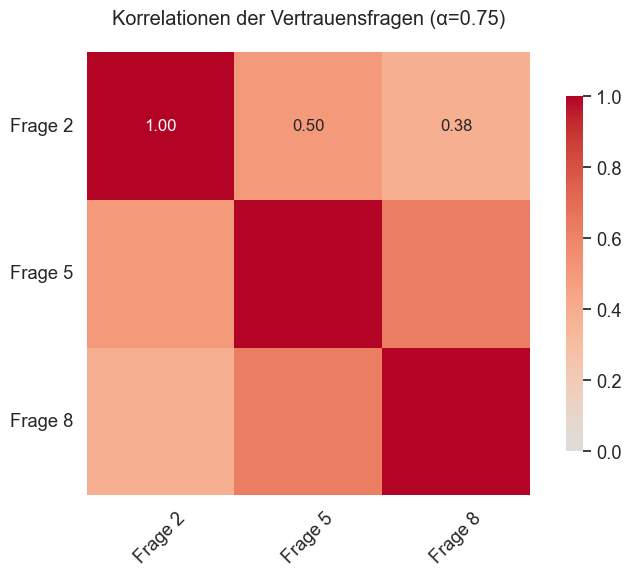

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

def extract_questions(data):
    questions = []
    for topic in ['CIA', 'Wirtschaft', 'Gesundheit', 'Physik']:
        q2 = data[f'{topic} - Wie Glaubwürdig fanden Sie die Antwort?']
        q5 = data[f'{topic} - Wie sehr vertrauen Sie den in der Antwort präsentierten Informationen?']
        q8 = data[f'{topic} - Wie sicher sind Sie, dass die Antwort korrekt ist?']
        
        df = pd.DataFrame({
            'Thema': topic,
            'Frage 2': q2,
            'Frage 5': q5,
            'Frage 8': q8
        })
        questions.append(df)
    return pd.concat(questions)

all_questions = pd.concat([
    extract_questions(with_sources),
    extract_questions(without_sources)
]).dropna()  # NA-Werte entfernen

def cronbach_alpha(df):
    items = df[['Frage 2', 'Frage 5', 'Frage 8']]
    n_items = items.shape[1]
    total_var = items.sum(axis=1).var(ddof=1)
    item_vars = items.var(ddof=1).sum()
    alpha = (n_items / (n_items - 1)) * (1 - (item_vars / total_var))
    return alpha

alpha_total = cronbach_alpha(all_questions)
print("Cronbach's Alpha (Gesamt):", round(alpha_total, 3))

print("\nInterpretation:")
print("α ≥ 0.9: Exzellent")
print("0.8 ≤ α < 0.9: Gut")
print("0.7 ≤ α < 0.8: Akzeptabel")
print("α < 0.7: Fragwürdig")

corr_matrix = all_questions[['Frage 2', 'Frage 5', 'Frage 8']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt=".2f", annot_kws={"size": 12}, square=True, 
            cbar_kws={'shrink': 0.8}, vmin=0, vmax=1)

plt.title(f'Korrelationen der Vertrauensfragen (α={alpha_total:.2f})', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Statistische Ergebnisse der Bewertungsdimensionen
Dimension            | Mit Quellen          | Ohne Quellen         | p-Wert     | Signifikanz
--------------------------------------------------------------------------------
Vorwissen            | 2.95 (SD=1.49)       | 3.25 (SD=1.63)       | 0.337     | n.s.
Glaubwürdigkeit      | 5.57 (SD=1.06)       | 5.44 (SD=1.04)       | 0.454     | n.s.
Verständlichkeit     | 5.55 (SD=1.19)       | 5.44 (SD=1.11)       | 0.428     | n.s.
Sachlichkeit         | 5.48 (SD=1.21)       | 5.23 (SD=1.17)       | 0.223     | n.s.
Vertrauen            | 5.27 (SD=1.17)       | 4.58 (SD=1.16)       | 0.001     | ***
Missverständnis-Risiko | 4.61 (SD=1.61)       | 4.44 (SD=1.78)       | 0.619     | n.s.
Ausführlichkeit      | 4.48 (SD=1.19)       | 3.96 (SD=1.14)       | 0.035     | *
Korrektheits-Sicherheit | 5.00 (SD=1.08)       | 4.52 (SD=1.34)       | 0.051     | †

Signifikanzniveaus: *** p < 0.001, ** p < 0.01, * p < 0.05, † p < 0.1, n.s. = nicht sign

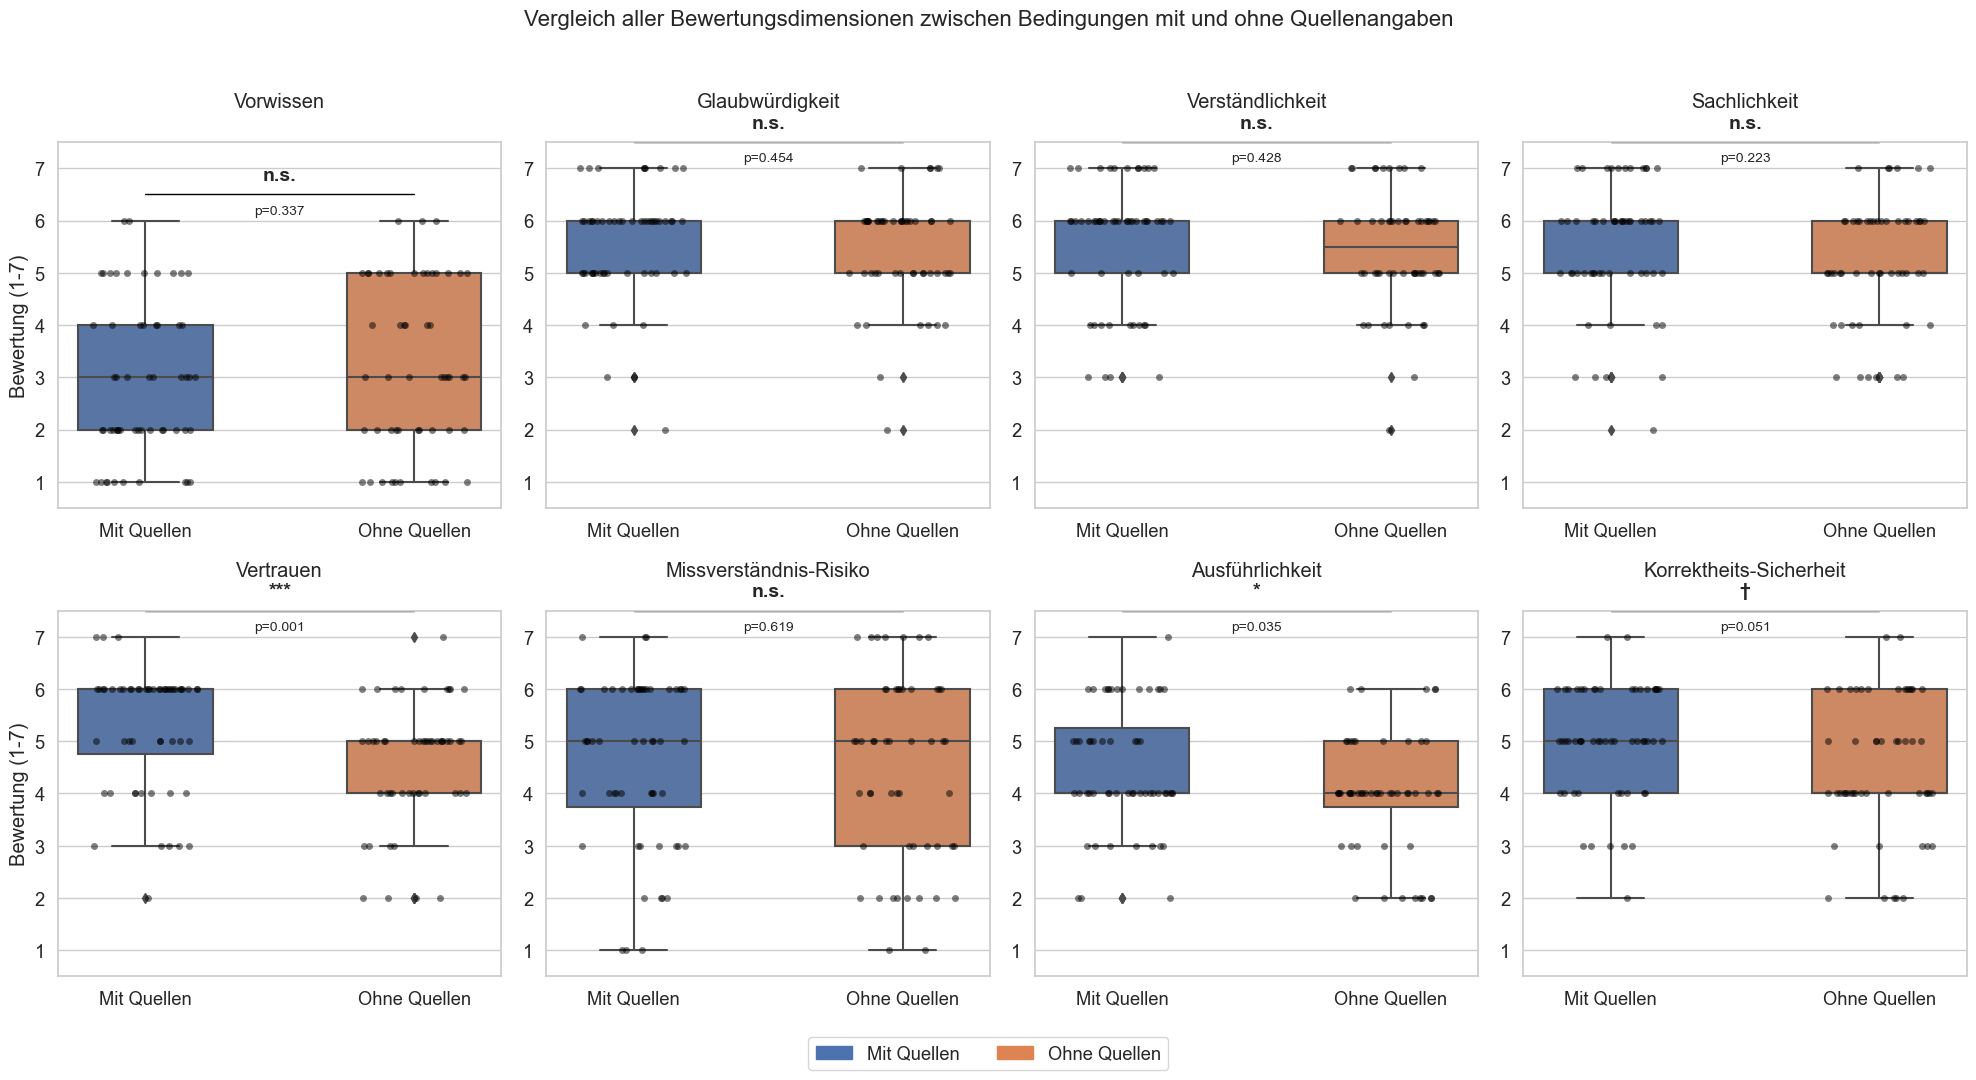

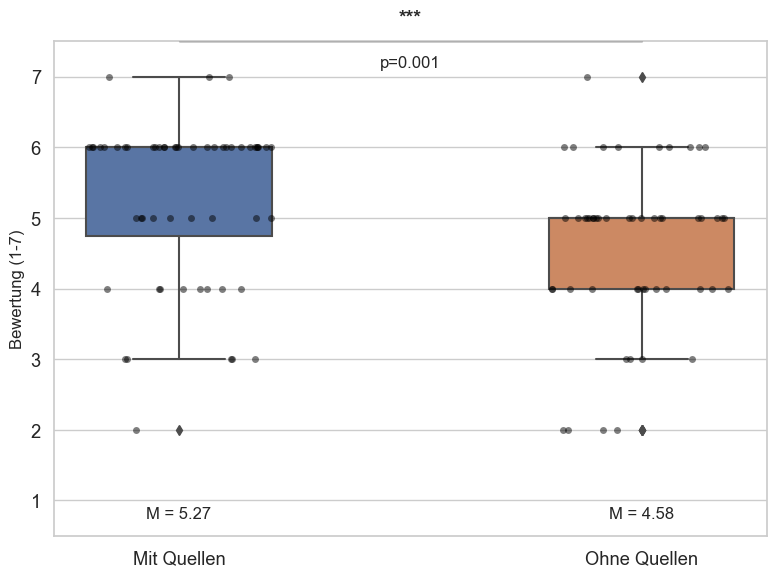

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu

with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

topics = ['CIA', 'Wirtschaft', 'Gesundheit', 'Physik']
questions = [
    'Wie viel Vorwissen haben Sie zu dem Thema des Textes?',
    'Wie Glaubwürdig fanden Sie die Antwort?',
    'Wie klar und verständlich war die Antwort?',
    'Wie sachlich fanden Sie die Antwort?',
    'Wie sehr vertrauen Sie den in der Antwort präsentierten Informationen?',
    'Wie wahrscheinlich ist es, dass die Antwort missverstanden werden könnte?',
    'Wie ausführlich fanden Sie die Antwort?',
    'Wie sicher sind Sie, dass die Antwort korrekt ist?'
]

data = []
for topic in topics:
    for question in questions:
        col_name = f"{topic} - {question}"
        
        if col_name in with_sources.columns:
            for val in with_sources[col_name].dropna():
                data.append({
                    'Thema': topic,
                    'Frage': question,
                    'Wert': val,
                    'Bedingung': 'Mit Quellen'
                })
        
        if col_name in without_sources.columns:
            for val in without_sources[col_name].dropna():
                data.append({
                    'Thema': topic,
                    'Frage': question,
                    'Wert': val,
                    'Bedingung': 'Ohne Quellen'
                })

df = pd.DataFrame(data)

short_questions = {
    questions[0]: "Vorwissen",
    questions[1]: "Glaubwürdigkeit",
    questions[2]: "Verständlichkeit",
    questions[3]: "Sachlichkeit",
    questions[4]: "Vertrauen",
    questions[5]: "Missverständnis-Risiko",
    questions[6]: "Ausführlichkeit",
    questions[7]: "Korrektheits-Sicherheit"
}

def get_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    elif p < 0.1: return '†'
    else: return 'n.s.'

results = {}

for question in questions:
    group1 = df[(df['Frage'] == question) & (df['Bedingung'] == 'Mit Quellen')]['Wert']
    group2 = df[(df['Frage'] == question) & (df['Bedingung'] == 'Ohne Quellen')]['Wert']
    
    if len(group1) > 0 and len(group2) > 0:
        stat, p = mannwhitneyu(group1, group2)
        m1, m2 = np.mean(group1), np.mean(group2)
        sd1, sd2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
        
        results[short_questions[question]] = {
            'p': p,
            'stars': get_stars(p),
            'Mit Quellen (M)': f"{m1:.2f} (SD={sd1:.2f})",
            'Ohne Quellen (M)': f"{m2:.2f} (SD={sd2:.2f})",
            'Unterschied': "signifikant" if p < 0.05 else "nicht signifikant"
        }

print("="*80)
print("Statistische Ergebnisse der Bewertungsdimensionen")
print("="*80)
print(f"{'Dimension':<20} | {'Mit Quellen':<20} | {'Ohne Quellen':<20} | {'p-Wert':<10} | Signifikanz")
print("-"*80)

for dim, res in results.items():
    print(f"{dim:<20} | {res['Mit Quellen (M)']:<20} | {res['Ohne Quellen (M)']:<20} | {res['p']:.3f}     | {res['stars']}")

print("\nSignifikanzniveaus: *** p < 0.001, ** p < 0.01, * p < 0.05, † p < 0.1, n.s. = nicht signifikant")

plt.figure(figsize=(20, 10))
sns.set(style="whitegrid", font_scale=1.2)
palette = {'Mit Quellen': '#4c72b0', 'Ohne Quellen': '#dd8452'}

for i, question in enumerate(questions):
    plt.subplot(2, 4, i+1)
    
    sns.boxplot(x='Bedingung', y='Wert', data=df[df['Frage'] == question], 
                palette=palette, width=0.5)
    sns.stripplot(x='Bedingung', y='Wert', data=df[df['Frage'] == question],
                 color='black', alpha=0.5, jitter=0.2)
    
    dim = short_questions[question]
    if dim in results:
        stars = results[dim]['stars']
        p = results[dim]['p']
        
        y_pos = df[df['Frage'] == question]['Wert'].max() + 0.5
        plt.plot([0, 1], [y_pos, y_pos], color='black', lw=1)
        plt.text(0.5, y_pos + 0.2, stars, ha='center', va='bottom', fontsize=14, fontweight='bold')
        plt.text(0.5, y_pos - 0.2, f'p={p:.3f}', ha='center', va='top', fontsize=10)
    
    plt.title(dim, pad=25)
    plt.xlabel('')
    plt.ylabel('Bewertung (1-7)' if i % 4 == 0 else '')
    plt.ylim(0.5, 7.5)

plt.suptitle('Vergleich aller Bewertungsdimensionen zwischen Bedingungen mit und ohne Quellenangaben', 
             y=1.02, fontsize=16)

handles = [plt.Rectangle((0,0),1,1, color=palette['Mit Quellen'], label='Mit Quellen'),
           plt.Rectangle((0,0),1,1, color=palette['Ohne Quellen'], label='Ohne Quellen')]
plt.figlegend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()

plt.savefig('fragen_vergleich_2x4.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid", font_scale=1.2)

vertrauen_data = df[df['Frage'] == questions[4]] 

ax = sns.boxplot(x='Bedingung', y='Wert', data=vertrauen_data, 
                palette=palette, width=0.4)
sns.stripplot(x='Bedingung', y='Wert', data=vertrauen_data,
             color='black', alpha=0.5, jitter=0.2)

vertrauen_res = results['Vertrauen']
y_pos = vertrauen_data['Wert'].max() + 0.5
plt.plot([0, 1], [y_pos, y_pos], color='black', lw=1)
plt.text(0.5, y_pos + 0.2, vertrauen_res['stars'], 
         ha='center', va='bottom', fontsize=14, fontweight='bold')
plt.text(0.5, y_pos - 0.2, f'p={vertrauen_res["p"]:.3f}', 
         ha='center', va='top', fontsize=12)

plt.xlabel('')
plt.ylabel('Bewertung (1-7)', fontsize=12)
plt.ylim(0.5, 7.5)

for i, condition in enumerate(['Mit Quellen', 'Ohne Quellen']):
    mean = vertrauen_data[vertrauen_data['Bedingung'] == condition]['Wert'].mean()
    plt.text(i, 0.7, f'M = {mean:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()

plt.savefig('vertrauen_vergleich.png', dpi=300, bbox_inches='tight')
plt.show()

Korrelationsanalyse zwischen ATI-Score und Glaubwürdigkeit:
Pearson-Korrelation (linearer Zusammenhang): r = 0.185, p = 0.3545
Spearman-Korrelation (monotoner Zusammenhang): ρ = 0.352, p = 0.0718


/var/folders/fg/mnsxwcgd44d0d911s38ny_f80000gn/T/ipykernel_2196/3978700594.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined_data['Durchschnittliche_Glaubwürdigkeit'] = combined_data[glaubw_cols].mean(axis=1)


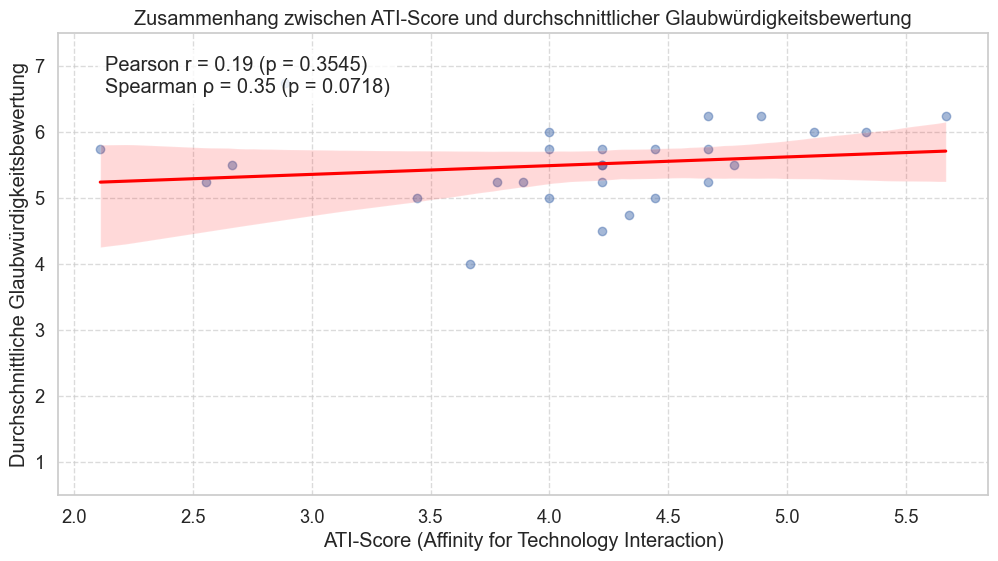


Korrelation nach Gruppen:
Mit Quellen: r = 0.174, p = 0.5513 (n = 14)
Ohne Quellen: r = 0.166, p = 0.5885 (n = 13)


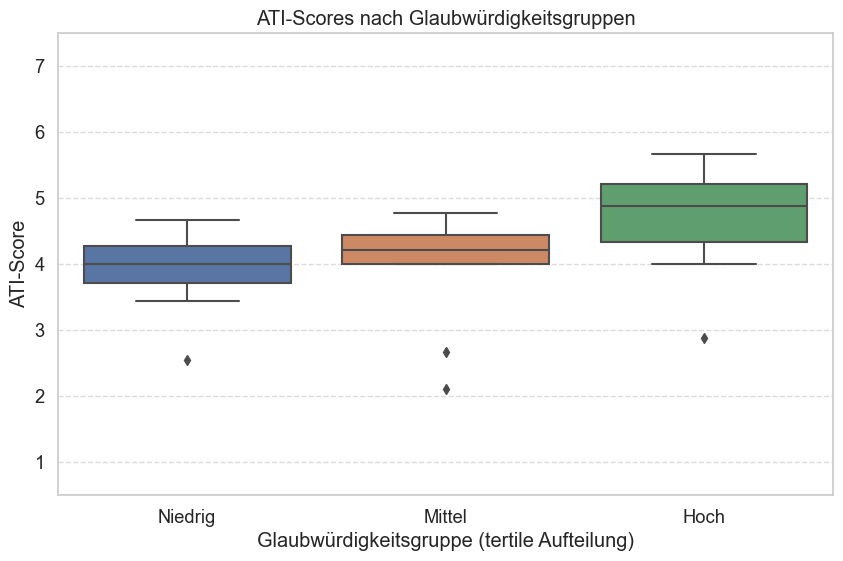

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

with_sources['Gruppe'] = 'Mit Quellen'
without_sources['Gruppe'] = 'Ohne Quellen'

combined_data = pd.concat([with_sources, without_sources])

glaubw_cols = [col for col in combined_data.columns if 'Glaubwürdig' in col]
combined_data['Durchschnittliche_Glaubwürdigkeit'] = combined_data[glaubw_cols].mean(axis=1)

ati_scores = combined_data['ATI_Score']
glaubw_scores = combined_data['Durchschnittliche_Glaubwürdigkeit']

valid_indices = ~np.isnan(ati_scores) & ~np.isnan(glaubw_scores)
ati_scores_clean = ati_scores[valid_indices]
glaubw_scores_clean = glaubw_scores[valid_indices]

pearson_r, pearson_p = stats.pearsonr(ati_scores_clean, glaubw_scores_clean)
spearman_r, spearman_p = stats.spearmanr(ati_scores_clean, glaubw_scores_clean)

print("Korrelationsanalyse zwischen ATI-Score und Glaubwürdigkeit:")
print(f"Pearson-Korrelation (linearer Zusammenhang): r = {pearson_r:.3f}, p = {pearson_p:.4f}")
print(f"Spearman-Korrelation (monotoner Zusammenhang): ρ = {spearman_r:.3f}, p = {spearman_p:.4f}")

slope, intercept, r_value, p_value, std_err = stats.linregress(ati_scores_clean, glaubw_scores_clean)

plt.figure(figsize=(12, 6))

sns.regplot(x=ati_scores_clean, y=glaubw_scores_clean, 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Zusammenhang zwischen ATI-Score und durchschnittlicher Glaubwürdigkeitsbewertung')
plt.xlabel('ATI-Score (Affinity for Technology Interaction)')
plt.ylabel('Durchschnittliche Glaubwürdigkeitsbewertung')
plt.ylim(0.5, 7.5)
plt.grid(True, linestyle='--', alpha=0.7)

plt.text(0.05, 0.95, 
         f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.4f})\nSpearman ρ = {spearman_r:.2f} (p = {spearman_p:.4f})",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

print("\nKorrelation nach Gruppen:")
for group in ['Mit Quellen', 'Ohne Quellen']:
    group_data = combined_data[combined_data['Gruppe'] == group]
    ati = group_data['ATI_Score']
    glaubw = group_data['Durchschnittliche_Glaubwürdigkeit']
    
    valid_idx = ~np.isnan(ati) & ~np.isnan(glaubw)
    ati_clean = ati[valid_idx]
    glaubw_clean = glaubw[valid_idx]
    
    if len(ati_clean) > 2:  
        r, p = stats.pearsonr(ati_clean, glaubw_clean)
        print(f"{group}: r = {r:.3f}, p = {p:.4f} (n = {len(ati_clean)})")
    else:
        print(f"{group}: Nicht genügend Daten für Korrelationsberechnung")

plt.figure(figsize=(10, 6))
combined_data['Glaubwürdigkeitsgruppe'] = pd.qcut(combined_data['Durchschnittliche_Glaubwürdigkeit'], 
                                                 q=3, 
                                                 labels=['Niedrig', 'Mittel', 'Hoch'])
sns.boxplot(x='Glaubwürdigkeitsgruppe', y='ATI_Score', data=combined_data)
plt.title('ATI-Scores nach Glaubwürdigkeitsgruppen')
plt.xlabel('Glaubwürdigkeitsgruppe (tertile Aufteilung)')
plt.ylabel('ATI-Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.5, 7.5)
plt.show()

/var/folders/fg/mnsxwcgd44d0d911s38ny_f80000gn/T/ipykernel_2196/2793351428.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Glaubwürdigkeit'] = df[cred_cols].mean(axis=1)
/var/folders/fg/mnsxwcgd44d0d911s38ny_f80000gn/T/ipykernel_2196/2793351428.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Glaubwürdigkeit'] = df[cred_cols].mean(axis=1)


<Figure size 1200x600 with 0 Axes>

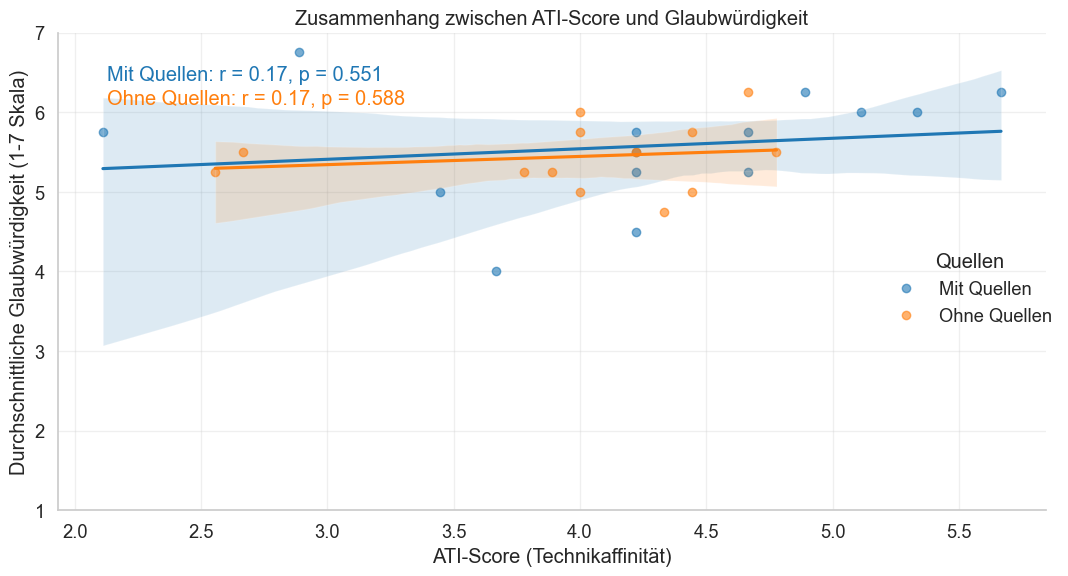

Statistische Kennwerte:

Mit Quellen:
- Korrelation (r): 0.17
- p-Wert: 0.5513
- Anzahl: 14
- M (Glaubwürdigkeit): 5.57 ± 0.73
- M (ATI): 4.24 ± 0.96

Ohne Quellen:
- Korrelation (r): 0.17
- p-Wert: 0.5885
- Anzahl: 13
- M (Glaubwürdigkeit): 5.44 ± 0.42
- M (ATI): 3.98 ± 0.68

Vergleich der Glaubwürdigkeit (mit vs. ohne Quellen):
t = 0.57, p = 0.5765


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr

with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

def extract_credibility(df):
    cred_cols = [col for col in df.columns if 'Glaubwürdig' in col]
    df['Glaubwürdigkeit'] = df[cred_cols].mean(axis=1)
    return df[['Glaubwürdigkeit', 'ATI_Score']]

with_sources_clean = extract_credibility(with_sources).assign(Quellen='Mit Quellen')
without_sources_clean = extract_credibility(without_sources).assign(Quellen='Ohne Quellen')
combined = pd.concat([with_sources_clean, without_sources_clean])

corr_with = pearsonr(with_sources_clean['ATI_Score'], with_sources_clean['Glaubwürdigkeit'])
corr_without = pearsonr(without_sources_clean['ATI_Score'], without_sources_clean['Glaubwürdigkeit'])

plt.figure(figsize=(12, 6))

sns.lmplot(x='ATI_Score', y='Glaubwürdigkeit', hue='Quellen', 
           data=combined, height=6, aspect=1.5,
           palette={'Mit Quellen': '#1f77b4', 'Ohne Quellen': '#ff7f0e'},
           scatter_kws={'alpha': 0.6})

plt.title('Zusammenhang zwischen ATI-Score und Glaubwürdigkeit')
plt.xlabel('ATI-Score (Technikaffinität)')
plt.ylabel('Durchschnittliche Glaubwürdigkeit (1-7 Skala)')
plt.grid(alpha=0.3)
plt.ylim(1, 7)

plt.text(0.05, 0.9, 
         f"Mit Quellen: r = {corr_with[0]:.2f}, p = {corr_with[1]:.3f}", 
         transform=plt.gca().transAxes,
         color='#1f77b4')
plt.text(0.05, 0.85, 
         f"Ohne Quellen: r = {corr_without[0]:.2f}, p = {corr_without[1]:.3f}", 
         transform=plt.gca().transAxes,
         color='#ff7f0e')

plt.tight_layout()
plt.show()

print("Statistische Kennwerte:")
print("\nMit Quellen:")
print(f"- Korrelation (r): {corr_with[0]:.2f}")
print(f"- p-Wert: {corr_with[1]:.4f}")
print(f"- Anzahl: {len(with_sources_clean)}")
print(f"- M (Glaubwürdigkeit): {with_sources_clean['Glaubwürdigkeit'].mean():.2f} ± {with_sources_clean['Glaubwürdigkeit'].std():.2f}")
print(f"- M (ATI): {with_sources_clean['ATI_Score'].mean():.2f} ± {with_sources_clean['ATI_Score'].std():.2f}")

print("\nOhne Quellen:")
print(f"- Korrelation (r): {corr_without[0]:.2f}")
print(f"- p-Wert: {corr_without[1]:.4f}")
print(f"- Anzahl: {len(without_sources_clean)}")
print(f"- M (Glaubwürdigkeit): {without_sources_clean['Glaubwürdigkeit'].mean():.2f} ± {without_sources_clean['Glaubwürdigkeit'].std():.2f}")
print(f"- M (ATI): {without_sources_clean['ATI_Score'].mean():.2f} ± {without_sources_clean['ATI_Score'].std():.2f}")

t_stat, p_val = stats.ttest_ind(
    with_sources_clean['Glaubwürdigkeit'],
    without_sources_clean['Glaubwürdigkeit'],
    equal_var=False
)
print(f"\nVergleich der Glaubwürdigkeit (mit vs. ohne Quellen):")
print(f"t = {t_stat:.2f}, p = {p_val:.4f}")

<Figure size 1200x600 with 0 Axes>

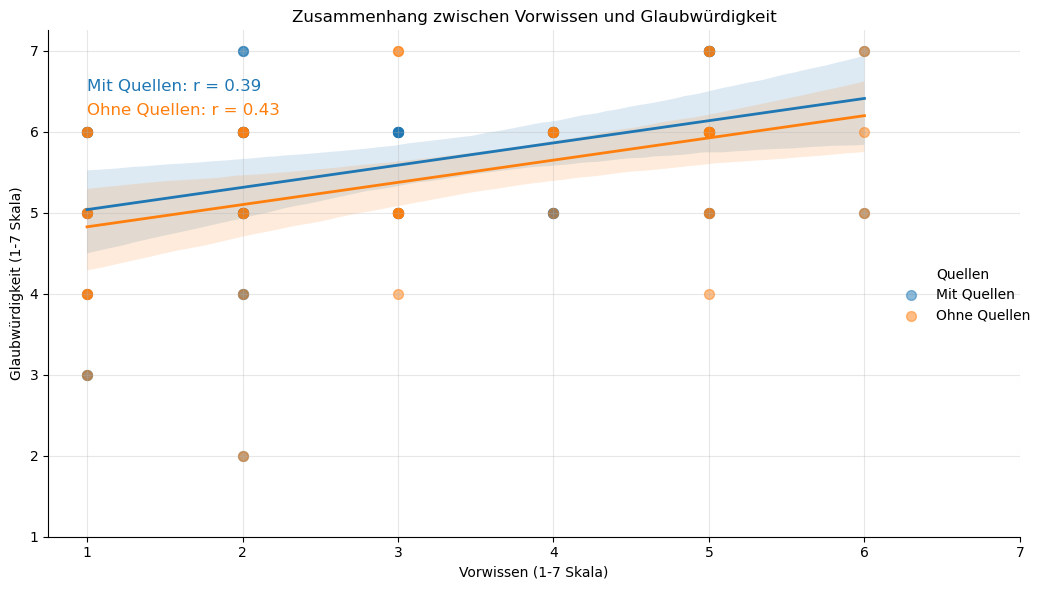


Korrelationen nach Thema und Quellenangabe:
     Quellen      Thema  Korrelation (r)   p-Wert  Stichprobengröße
 Mit Quellen        CIA         0.568722 0.033814              14.0
 Mit Quellen Gesundheit         0.357685 0.209257              14.0
 Mit Quellen     Physik         0.568722 0.033814              14.0
 Mit Quellen Wirtschaft         0.065339 0.824379              14.0
Ohne Quellen        CIA         0.541482 0.055978              13.0
Ohne Quellen Gesundheit         0.431556 0.140896              13.0
Ohne Quellen     Physik         0.248334 0.413302              13.0
Ohne Quellen Wirtschaft         0.431556 0.140896              13.0

Gesamtkorrelationen:
Mit Quellen: r = 0.39
Ohne Quellen: r = 0.43

Vergleich der Korrelationen (Fisher's z-Test):
z = -0.27, p = 0.7870


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr

with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

def extract_knowledge_credibility(df):
    knowledge_cols = [
        'CIA - Wie viel Vorwissen haben Sie zu dem Thema des Textes?',
        'Wirtschaft - Wie viel Vorwissen haben Sie zu dem Thema des Textes?',
        'Gesundheit - Wie viel Vorwissen haben Sie zu dem Thema des Textes?',
        'Physik - Wie viel Vorwissen haben Sie zu dem Thema des Textes?'
    ]
    
    credibility_cols = [
        'CIA - Wie Glaubwürdig fanden Sie die Antwort?',
        'Wirtschaft - Wie Glaubwürdig fanden Sie die Antwort?',
        'Gesundheit - Wie Glaubwürdig fanden Sie die Antwort?',
        'Physik - Wie Glaubwürdig fanden Sie die Antwort?'
    ]
    
    knowledge = df[knowledge_cols].melt(var_name='Thema', value_name='Vorwissen')
    credibility = df[credibility_cols].melt(var_name='Thema', value_name='Glaubwürdigkeit')
    
    combined = pd.concat([knowledge['Vorwissen'], credibility['Glaubwürdigkeit']], axis=1)
    combined['Thema'] = knowledge['Thema'].str.extract(r'^(.*?) - ')[0]
    
    return combined

with_sources_data = extract_knowledge_credibility(with_sources).assign(Quellen='Mit Quellen')
without_sources_data = extract_knowledge_credibility(without_sources).assign(Quellen='Ohne Quellen')
all_data = pd.concat([with_sources_data, without_sources_data]).dropna()

corr_with = all_data[all_data['Quellen'] == 'Mit Quellen'][['Vorwissen', 'Glaubwürdigkeit']].corr().iloc[0,1]
corr_without = all_data[all_data['Quellen'] == 'Ohne Quellen'][['Vorwissen', 'Glaubwürdigkeit']].corr().iloc[0,1]

plt.figure(figsize=(12, 6))
sns.lmplot(x='Vorwissen', y='Glaubwürdigkeit', hue='Quellen', 
           data=all_data, height=6, aspect=1.5,
           palette={'Mit Quellen': '#1f77b4', 'Ohne Quellen': '#ff7f0e'},
           scatter_kws={'alpha': 0.5, 's': 50},
           line_kws={'linewidth': 2})

plt.title('Zusammenhang zwischen Vorwissen und Glaubwürdigkeit')
plt.xlabel('Vorwissen (1-7 Skala)')
plt.ylabel('Glaubwürdigkeit (1-7 Skala)')
plt.xticks(range(1, 8))
plt.yticks(range(1, 8))
plt.grid(alpha=0.3)

plt.text(1, 6.5, 
         f"Mit Quellen: r = {corr_with:.2f}", 
         color='#1f77b4', fontsize=12)
plt.text(1, 6.2, 
         f"Ohne Quellen: r = {corr_without:.2f}", 
         color='#ff7f0e', fontsize=12)

plt.tight_layout()
plt.show()

def calculate_correlation_stats(group_data):
    r, p = pearsonr(group_data['Vorwissen'], group_data['Glaubwürdigkeit'])
    n = len(group_data)
    return pd.Series({'Korrelation (r)': r, 'p-Wert': p, 'Stichprobengröße': n})

results = all_data.groupby(['Quellen', 'Thema']).apply(calculate_correlation_stats).reset_index()
print("\nKorrelationen nach Thema und Quellenangabe:")
print(results.to_string(index=False))

print("\nGesamtkorrelationen:")
print(f"Mit Quellen: r = {corr_with:.2f}")
print(f"Ohne Quellen: r = {corr_without:.2f}")

def compare_correlations(r1, r2, n1, n2):
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    se_diff = np.sqrt(1/(n1-3) + 1/(n2-3))
    z = (z1 - z2)/se_diff
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p

z_score, p_value = compare_correlations(corr_with, corr_without, 
                                       len(with_sources_data), 
                                       len(without_sources_data))
print(f"\nVergleich der Korrelationen (Fisher's z-Test):")
print(f"z = {z_score:.2f}, p = {p_value:.4f}")

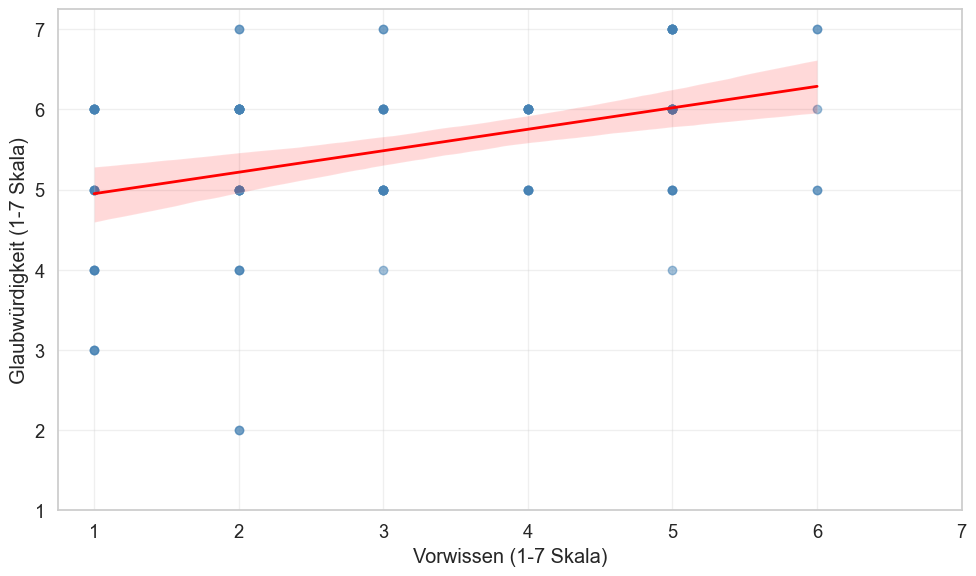

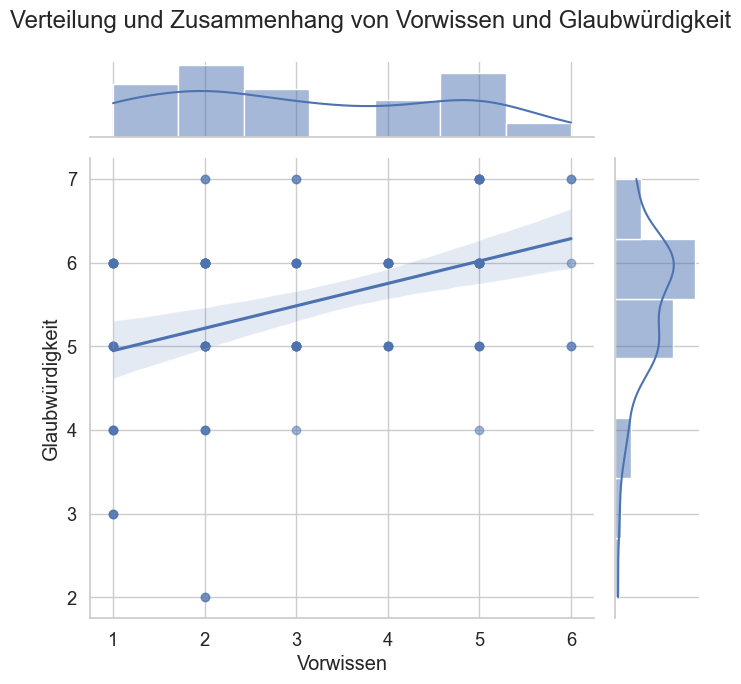


Statistische Analyse des Zusammenhangs:
Pearson-Korrelationskoeffizient: r = 0.400
Signifikanzniveau: p = 0.0000
Stichprobengröße: n = 108
Effektstärkeinterpretation: moderater Zusammenhang

Zusätzliche deskriptive Statistiken:
       Vorwissen  Glaubwürdigkeit
count     108.00           108.00
mean        3.09             5.51
std         1.56             1.05
min         1.00             2.00
25%         2.00             5.00
50%         3.00             6.00
75%         5.00             6.00
max         6.00             7.00

Korrelationsmatrix:
                 Vorwissen  Glaubwürdigkeit
Vorwissen              1.0              0.4
Glaubwürdigkeit        0.4              1.0


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr

with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

def extract_all_knowledge_credibility(df):
    knowledge_values = []
    credibility_values = []
    
    topics = ['CIA', 'Wirtschaft', 'Gesundheit', 'Physik']
    
    for topic in topics:
        knowledge_col = f"{topic} - Wie viel Vorwissen haben Sie zu dem Thema des Textes?"
        credibility_col = f"{topic} - Wie Glaubwürdig fanden Sie die Antwort?"
        
        if knowledge_col in df.columns and credibility_col in df.columns:
            knowledge = df[knowledge_col].dropna()
            credibility = df[credibility_col].dropna()
            
            min_len = min(len(knowledge), len(credibility))
            knowledge_values.extend(knowledge[:min_len])
            credibility_values.extend(credibility[:min_len])
    
    return pd.DataFrame({
        'Vorwissen': knowledge_values,
        'Glaubwürdigkeit': credibility_values
    })

all_data = pd.concat([
    extract_all_knowledge_credibility(with_sources),
    extract_all_knowledge_credibility(without_sources)
]).dropna()

corr_coef, p_value = pearsonr(all_data['Vorwissen'], all_data['Glaubwürdigkeit'])
n = len(all_data)

def describe_correlation(r):
    abs_r = abs(r)
    if abs_r >= 0.5:
        return "starker Zusammenhang"
    elif abs_r >= 0.3:
        return "moderater Zusammenhang"
    elif abs_r >= 0.1:
        return "schwacher Zusammenhang"
    else:
        return "kein nennenswerter Zusammenhang"

plt.figure(figsize=(10, 6))
sns.regplot(x='Vorwissen', y='Glaubwürdigkeit', data=all_data,
            scatter_kws={'alpha': 0.5, 'color': 'steelblue'},
            line_kws={'color': 'red', 'linewidth': 2})

plt.xlabel('Vorwissen (1-7 Skala)')
plt.ylabel('Glaubwürdigkeit (1-7 Skala)')
plt.xticks(range(1, 8))
plt.yticks(range(1, 8))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

joint_plot = sns.jointplot(x='Vorwissen', y='Glaubwürdigkeit', data=all_data,
                          kind='reg', height=7,
                          joint_kws={'scatter_kws': {'alpha': 0.5}},
                          marginal_kws={'bins': 7})
joint_plot.fig.suptitle('Verteilung und Zusammenhang von Vorwissen und Glaubwürdigkeit')
plt.tight_layout()
plt.show()

print("\nStatistische Analyse des Zusammenhangs:")
print(f"Pearson-Korrelationskoeffizient: r = {corr_coef:.3f}")
print(f"Signifikanzniveau: p = {p_value:.4f}")
print(f"Stichprobengröße: n = {n}")
print(f"Effektstärkeinterpretation: {describe_correlation(corr_coef)}")

print("\nZusätzliche deskriptive Statistiken:")
print(all_data.describe().round(2))

print("\nKorrelationsmatrix:")
print(all_data.corr().round(3))

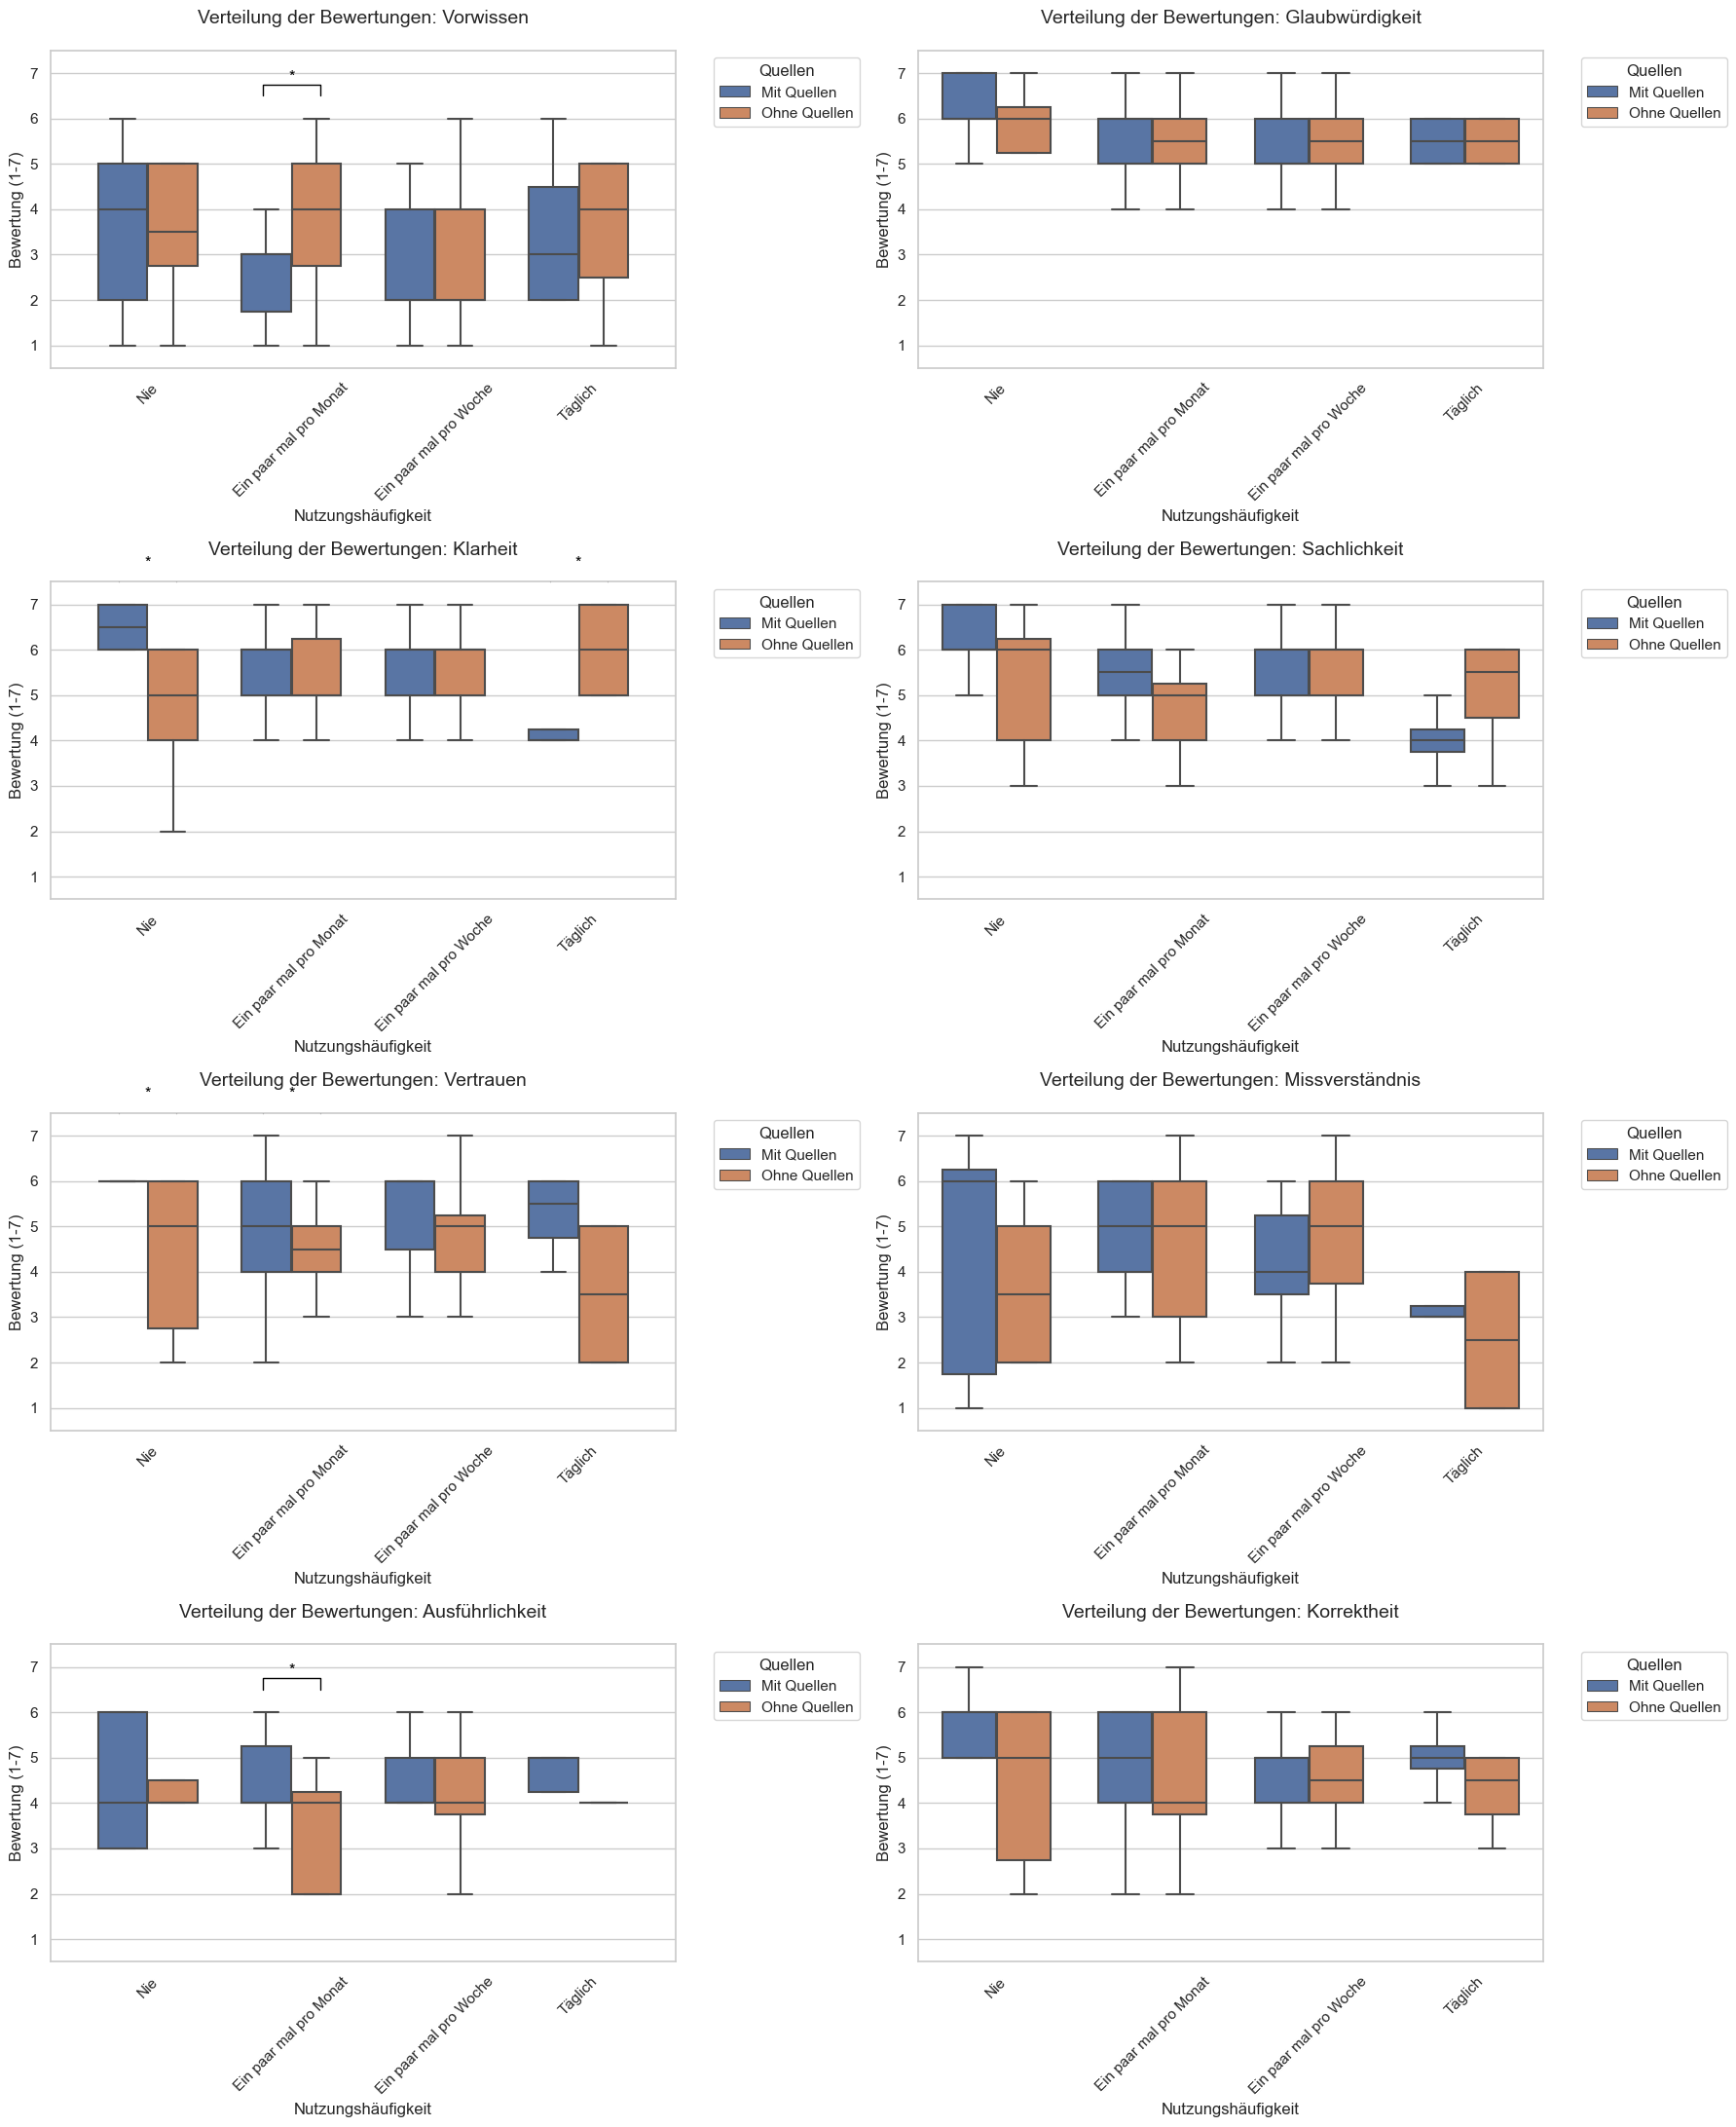

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
from itertools import combinations

with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

columns_1_8 = ['Vorwissen', 'Glaubwürdigkeit', 'Klarheit', 'Sachlichkeit', 
               'Vertrauen', 'Missverständnis', 'Ausführlichkeit', 'Korrektheit']

nutzung_order = ['Nie', 'Ein paar mal pro Monat', 'Ein paar mal pro Woche', 'Täglich']

def prepare_data(df, has_sources=True):
    topics = ['CIA', 'Wirtschaft', 'Gesundheit', 'Physik']
    data = []
    
    for topic in topics:
        topic_cols = [f"{topic} - {col}" for col in [
            "Wie viel Vorwissen haben Sie zu dem Thema des Textes?",
            "Wie Glaubwürdig fanden Sie die Antwort?",
            "Wie klar und verständlich war die Antwort?",
            "Wie sachlich fanden Sie die Antwort?",
            "Wie sehr vertrauen Sie den in der Antwort präsentierten Informationen?",
            "Wie wahrscheinlich ist es, dass die Antwort missverstanden werden könnte?",
            "Wie ausführlich fanden Sie die Antwort?",
            "Wie sicher sind Sie, dass die Antwort korrekt ist?"
        ]]
        
        topic_data = df[topic_cols].copy()
        topic_data.columns = columns_1_8
        topic_data['Thema'] = topic
        topic_data['Nutzungshäufigkeit'] = df['Wie oft nutzen Sie KI-Chat-Systeme zur Informationsbeschaffung?']
        data.append(topic_data)
    
    combined = pd.concat(data)
    combined['Hat Quellen'] = 'Mit Quellen' if has_sources else 'Ohne Quellen'
    
    combined['Nutzungshäufigkeit'] = pd.Categorical(
        combined['Nutzungshäufigkeit'],
        categories=nutzung_order,
        ordered=True
    )
    
    return combined

with_sources_prepared = prepare_data(with_sources, True)
without_sources_prepared = prepare_data(without_sources, False)
all_data = pd.concat([with_sources_prepared, without_sources_prepared])

def add_stat_annotations(ax, data, x, y, hue=None, order=None, hue_order=None):
    if hue is not None:
        hue_groups = data[hue].unique()
        if len(hue_groups) == 2:
            for nutzung in order:
                group1 = data[(data[x] == nutzung) & (data[hue] == hue_groups[0])][y]
                group2 = data[(data[x] == nutzung) & (data[hue] == hue_groups[1])][y]
                
                if len(group1) > 1 and len(group2) > 1:
                    _, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                    
                    if p_value < 0.05:
                        pos = order.index(nutzung)
                        if hue_order is not None:
                            hue_pos = {hue_order[0]: pos-0.2, hue_order[1]: pos+0.2}
                        else:
                            hue_pos = {hue_groups[0]: pos-0.2, hue_groups[1]: pos+0.2}
                        
                        y_max = max(group1.max(), group2.max())
                        y_range = data[y].max() - data[y].min()
                        line_y = y_max + 0.1 * y_range
                        bracket_height = 0.05 * y_range
                        
                        ax.plot([hue_pos[hue_groups[0]], hue_pos[hue_groups[0]], hue_pos[hue_groups[1]], hue_pos[hue_groups[1]]], 
                                [line_y, line_y + bracket_height, line_y + bracket_height, line_y], 
                                lw=1, color='black')
                        
                        ax.text((hue_pos[hue_groups[0]] + hue_pos[hue_groups[1]])/2, line_y + bracket_height, 
                                '*' if p_value < 0.05 else '', 
                                ha='center', va='bottom', color='black', fontsize=12)
    
    if hue is not None:
        for source in hue_groups:
            subset = data[data[hue] == source]
            valid_groups = [nutzung for nutzung in order 
                          if (subset[x] == nutzung).sum() >= 2 and nutzung in subset[x].unique()]
            
            if len(valid_groups) >= 2:
                groups = [subset[subset[x] == nutzung][y] for nutzung in valid_groups]
                h_stat, p_value = stats.kruskal(*groups)
                
                if p_value < 0.05:
                    try:
                        tukey_data = subset[subset[x].isin(valid_groups)].copy()
                        tukey_data = tukey_data[[x, y]].dropna()
                        
                        tukey = pairwise_tukeyhsd(tukey_data[y], tukey_data[x])
                        
                        sig_pairs = []
                        for i in range(len(tukey.groups)):
                            for j in range(i+1, len(tukey.groups)):
                                if tukey.pvalues[i,j] < 0.05:
                                    sig_pairs.append((tukey.groups[i], tukey.groups[j]))
                        
                        y_max = subset[y].max()
                        y_range = data[y].max() - data[y].min()
                        bracket_level = 1.15 if source == hue_groups[0] else 1.3
                        
                        for pair in sig_pairs:
                            x1 = order.index(pair[0])
                            x2 = order.index(pair[1])
                            
                            x_offset = -0.2 if source == hue_groups[0] else 0.2
                            x1 += x_offset
                            x2 += x_offset
                            
                            line_y = y_max + bracket_level * 0.05 * y_range
                            bracket_height = 0.03 * y_range
                            
                            ax.plot([x1, x1, x2, x2], 
                                    [line_y, line_y + bracket_height, line_y + bracket_height, line_y], 
                                    lw=1, color='black')
                            
                            ax.text((x1+x2)*0.5, line_y + bracket_height, '*', 
                                    ha='center', va='bottom', color='black', fontsize=10)
                            
                            bracket_level += 0.15
                    
                    except Exception as e:
                        continue

plt.figure(figsize=(18, 22))
sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12

for i, col in enumerate(columns_1_8, 1):
    plt.subplot(4, 2, i)
    ax = sns.boxplot(
        data=all_data, 
        x='Nutzungshäufigkeit', 
        y=col, 
        order=nutzung_order,
        hue='Hat Quellen',
        palette=['#4c72b0', '#dd8452'],
        showfliers=False,
        width=0.7
    )
    
    plt.title(f'Verteilung der Bewertungen: {col}', fontsize=14, pad=20)
    plt.ylim(0.5, 7.5)
    plt.ylabel('Bewertung (1-7)', fontsize=12)
    plt.xlabel('Nutzungshäufigkeit', fontsize=12)
    plt.xticks(rotation=45)
    
    add_stat_annotations(ax, all_data, 'Nutzungshäufigkeit', col, 
                        hue='Hat Quellen', order=nutzung_order, 
                        hue_order=['Mit Quellen', 'Ohne Quellen'])
    
    plt.legend(title='Quellen', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()

plt.show()


STATISTISCHE VERGLEICHE ZWISCHEN DEN GRUPPEN

Vergleich 'Wichtigkeit Quellen' (Mit) vs 'Sinnhaftigkeit Quellen' (Ohne):
t(25) = -1.75, p = 0.094
Effektstärke (Cohen's d): 0.67

DESKRIPTIVE STATISTIK FÜR ALLE FRAGEN

Frage: Quellen angesehen (Mit Quellen)
- Mittelwert: 3.79
- Median: 4.50
- Standardabweichung: 2.22
- Range: 1 bis 7
- Stichprobengröße: n = 14

Frage: Wichtigkeit Quellen (Mit Quellen)
- Mittelwert: 5.50
- Median: 6.00
- Standardabweichung: 1.61
- Range: 3 bis 7
- Stichprobengröße: n = 14

Frage: Vertrauen durch Quellen (Mit Quellen)
- Mittelwert: 4.21
- Median: 5.00
- Standardabweichung: 2.36
- Range: 1 bis 7
- Stichprobengröße: n = 14

Frage: Sinnhaftigkeit Quellen (Ohne Quellen)
- Mittelwert: 6.38
- Median: 7.00
- Standardabweichung: 0.96
- Range: 4 bis 7
- Stichprobengröße: n = 13


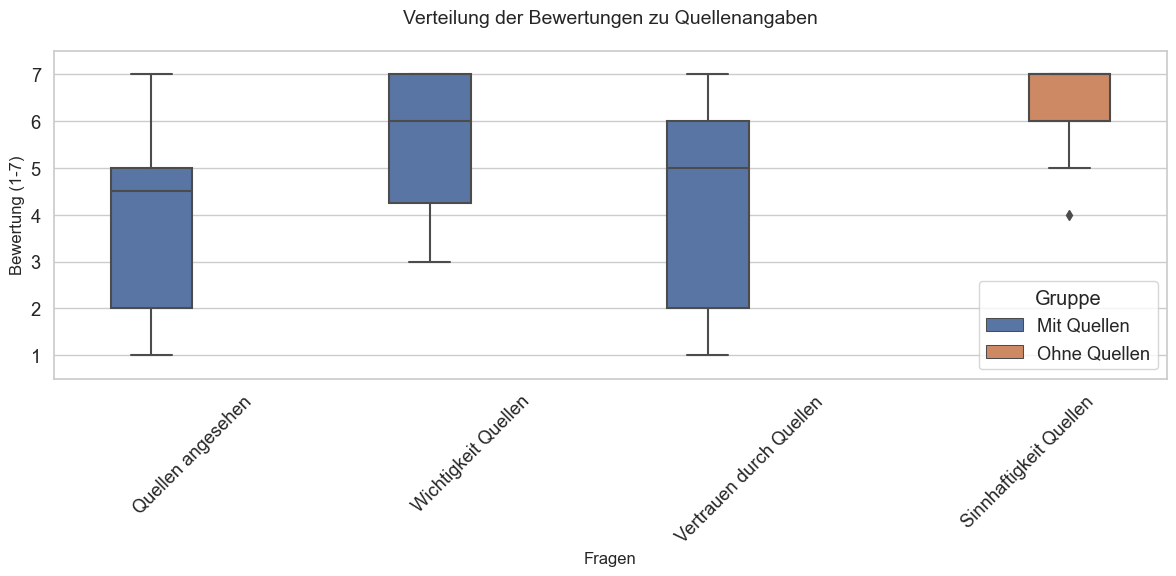

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats  

with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

data_for_plot = []
results = []

quellen_fragen_mit = {
    "Quellen angesehen": "Wie genau haben Sie sich die Quellen des KI-Systems angesehen?",
    "Wichtigkeit Quellen": "Wie wichtig sind Ihnen Quellenangaben bei KI-generierten Antworten?  ",
    "Vertrauen durch Quellen": "Wie sehr hat die Angabe von Quellen Ihr Vertrauen in die Antwort beeinflusst? "
}

for name, frage in quellen_fragen_mit.items():
    temp_df = with_sources[[frage]].copy()
    temp_df.columns = ['Wert']
    temp_df['Frage'] = name
    temp_df['Gruppe'] = 'Mit Quellen'
    data_for_plot.append(temp_df)
    
    stats_result = {  
        'Frage': name,
        'Gruppe': 'Mit Quellen',
        'Mittelwert': temp_df['Wert'].mean(),
        'Median': temp_df['Wert'].median(),
        'Standardabweichung': temp_df['Wert'].std(),
        'Minimum': temp_df['Wert'].min(),
        'Maximum': temp_df['Wert'].max(),
        'Anzahl': len(temp_df)
    }
    results.append(stats_result)

quellen_frage_ohne = "Für wie sinnvoll erachten Sie Quellenangaben in einem KI-Chat? "
temp_df = without_sources[[quellen_frage_ohne]].copy()
temp_df.columns = ['Wert']
temp_df['Frage'] = "Sinnhaftigkeit Quellen"
temp_df['Gruppe'] = 'Ohne Quellen'
data_for_plot.append(temp_df)

stats_result = {  
    'Frage': "Sinnhaftigkeit Quellen",
    'Gruppe': 'Ohne Quellen',
    'Mittelwert': temp_df['Wert'].mean(),
    'Median': temp_df['Wert'].median(),
    'Standardabweichung': temp_df['Wert'].std(),
    'Minimum': temp_df['Wert'].min(),
    'Maximum': temp_df['Wert'].max(),
    'Anzahl': len(temp_df)
}
results.append(stats_result)

plot_data = pd.concat(data_for_plot)
results_df = pd.DataFrame(results)

print("\n" + "="*50)
print("STATISTISCHE VERGLEICHE ZWISCHEN DEN GRUPPEN")
print("="*50)

group1 = with_sources[quellen_fragen_mit["Wichtigkeit Quellen"]]
group2 = without_sources[quellen_frage_ohne]

t_stat, p_value = scipy_stats.ttest_ind(group1, group2, equal_var=False)  
print(f"\nVergleich 'Wichtigkeit Quellen' (Mit) vs 'Sinnhaftigkeit Quellen' (Ohne):")
print(f"t({len(group1)+len(group2)-2}) = {t_stat:.2f}, p = {p_value:.3f}")
print(f"Effektstärke (Cohen's d): {abs((group1.mean() - group2.mean())) / ((group1.std()**2 + group2.std()**2)/2)**0.5:.2f}")

print("\n" + "="*50)
print("DESKRIPTIVE STATISTIK FÜR ALLE FRAGEN")
print("="*50)

for _, row in results_df.iterrows():
    print(f"\nFrage: {row['Frage']} ({row['Gruppe']})")
    print(f"- Mittelwert: {row['Mittelwert']:.2f}")
    print(f"- Median: {row['Median']:.2f}")
    print(f"- Standardabweichung: {row['Standardabweichung']:.2f}")
    print(f"- Range: {row['Minimum']:.0f} bis {row['Maximum']:.0f}")
    print(f"- Stichprobengröße: n = {row['Anzahl']}")

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

palette = {'Mit Quellen': '#4c72b0', 'Ohne Quellen': '#dd8452'}

ax = sns.boxplot(x='Frage', y='Wert', hue='Gruppe', data=plot_data, 
                palette=palette, width=0.6, showfliers=True)

plt.title('Verteilung der Bewertungen zu Quellenangaben', fontsize=14, pad=20)
plt.ylabel('Bewertung (1-7)', fontsize=12)
plt.xlabel('Fragen', fontsize=12)
plt.ylim(0.5, 7.5)
plt.xticks(rotation=45)
plt.legend(title='Gruppe')

plt.tight_layout()
plt.show()

In [35]:
import pandas as pd

with_sources = pd.read_csv('final_data/with_sources_ati.csv')
without_sources = pd.read_csv('final_data/without_sources_ati.csv')

all_participants = pd.concat([with_sources, without_sources])

print("="*50)
print("DEMOGRAFISCHE ANALYSE DER TEILNEHMERSCHAFT")
print("="*50)

gender_dist = all_participants['Geben Sie ihr Geschlecht an.'].value_counts(normalize=True) * 100
print("\n1. Geschlechterverteilung:")
print(gender_dist.round(1).apply(lambda x: f"{x}%").to_string(header=False))

print("\n2. Altersverteilung:")
print(f"Jüngster Teilnehmer: {int(all_participants['Wie alt sind Sie?'].min())} Jahre")
print(f"Ältester Teilnehmer: {int(all_participants['Wie alt sind Sie?'].max())} Jahre")
print(f"Durchschnittsalter: {all_participants['Wie alt sind Sie?'].mean():.1f} Jahre")
print(f"Median-Alter: {all_participants['Wie alt sind Sie?'].median():.1f} Jahre")

age_bins = [18, 25, 35, 50, 70]
age_labels = ["18-25", "26-35", "36-50", "51+"]
age_dist = pd.cut(all_participants['Wie alt sind Sie?'], bins=age_bins, labels=age_labels).value_counts(normalize=True) * 100
print("\nAltersgruppen:")
print(age_dist.round(1).apply(lambda x: f"{x}%").to_string(header=False))

print("\n3. Höchste Bildungsabschlüsse:")
education_dist = all_participants['Welchen höchsten Bildungsabschluss haben Sie erreicht?'].value_counts(normalize=True) * 100
print(education_dist.round(1).apply(lambda x: f"{x}%").to_string(header=False))

print("\n4. Nutzungshäufigkeit von KI-Chatsystemen:")
usage_dist = all_participants['Wie oft nutzen Sie KI-Chat-Systeme zur Informationsbeschaffung?'].value_counts(normalize=True) * 100
print(usage_dist.round(1).apply(lambda x: f"{x}%").to_string(header=False))

print("\n" + "="*50)

DEMOGRAFISCHE ANALYSE DER TEILNEHMERSCHAFT

1. Geschlechterverteilung:
männlich    74.1%
weiblich    25.9%

2. Altersverteilung:
Jüngster Teilnehmer: 21 Jahre
Ältester Teilnehmer: 65 Jahre
Durchschnittsalter: 29.3 Jahre
Median-Alter: 24.0 Jahre

Altersgruppen:
18-25    73.1%
51+      15.4%
26-35    11.5%
36-50     0.0%

3. Höchste Bildungsabschlüsse:
Abitur                    48.1%
Bachelor                  37.0%
Techniker                  3.7%
Dipl. Ing. Architektin     3.7%
Diplom                     3.7%
Master                     3.7%

4. Nutzungshäufigkeit von KI-Chatsystemen:
Ein paar mal pro Monat    40.7%
Ein paar mal pro Woche    33.3%
Nie                       18.5%
Täglich                    7.4%

